In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import random

2025-05-26 15:28:16.962279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748266096.978810  563888 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748266096.983447  563888 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 15:28:17.000075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications import resnet50, vgg16, inception_v3, mobilenet_v2, mobilenet_v3

all_models = {
    "ResNet50": (ResNet50(weights='imagenet'), resnet50.preprocess_input),
    "VGG16": (VGG16(weights='imagenet'), vgg16.preprocess_input),
    "MobileNetV2": (MobileNetV2(weights='imagenet'), mobilenet_v2.preprocess_input),
    # "MobileNetV3Small": (MobileNetV3Small(weights='imagenet'), mobilenet_v3.preprocess_input),
    "InceptionV3": (InceptionV3(weights='imagenet'), inception_v3.preprocess_input),
    }

2025-05-26 15:28:22.691571: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-26 15:28:24.091732: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 15:28:24.199493: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 15:28:24.268979: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-05-26 15:28:24.401740: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-05-26 15:28:24.416758: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [4]:
def preprocess(image, preprocess_input, size=(224,224)):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size)
  image = preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

def display_images(image, description, model):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()


def display_perturbation(pertubation):
  plt.imshow(pertubation * 0.5 + 0.5)
  plt.show()
  

def tensor_range(tensor):
  print(f"Min: {tf.reduce_min(tensor)}, Max: {tf.reduce_max(tensor)}")

In [5]:
def save_image(tensor, target_folder, filename):

    # Remove batch dimension if present
    if len(tensor.shape) == 4:
        tensor = tensor[0]

    # Encode as JPEG
    encoded = tf.io.encode_jpeg(tensor)

    # Ensure the directory exists
    os.makedirs(target_folder, exist_ok=True)

    # Save to file
    path = os.path.join(target_folder, filename)
    tf.io.write_file(path, encoded)
    # print(f"Image saved to: {path}")


def load_and_preprocess_image(path):
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3)
    return tf.cast(img, tf.float32)

In [6]:
def plot_histogram(data, total, label, title, target_label = None):
    if target_label != None:
        plt.bar([label, target_label, "other"], [data[label], data[target_label], total - data[label] - data[target_label]])
        print(f"Targeted evasion rate {((data[target_label]) / total) * 100: .2f}")
    else:
        plt.bar([label, "other"], [data[label], total - data[label]])
        print(f"Evasion rate {((total - data[label]) / total) * 100: .2f}")
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Histogram: ' + title)
    plt.show()


def test_model(img_tensors, model, preprocess, decode, flag):
    l = {}
    target_size = (299, 299) if flag == 1 else (224, 224)

    processed_images = []
    for image in img_tensors:
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32)
        processed_images.append(image)

    batch = tf.stack(processed_images)
    batch = preprocess(batch)
    predictions = model.predict(batch)
    decoded = decode(predictions, top=1)
    
    for d in decoded:
        _, label, conf = d[0]
        # print(f"Predicted: {label} with {conf*100:.2f}% confidence")
        if label not in l.keys():
            l[label] = 1
        else:
            l[label] += 1

    return l

## Targeted Attacks

In [13]:
# For clipping the input vector
def clip_delta(t, eps):
    return tf.clip_by_value(t, -eps, eps)


# Generates targeted adversarial images
def generate_adv_pertubation(model_name, model, preprocessor, optimizer, loss, img, delta, label, target_label, eps, max_iterations=500):
    # delta = tf.Variable(tf.zeros_like(img), trainable=True)
    
    for step in range(max_iterations):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            
            if model_name == "InceptionV3":
                adv = preprocess(img + delta, preprocessor, (299, 299))
            else:
                adv = preprocess(img + delta, preprocessor)

            preds = model(adv,training=False)
            # print(preds)
            originalLoss = -loss(tf.convert_to_tensor([label]), preds)
            targetLoss = loss(tf.convert_to_tensor([target_label]), preds)
            totalLoss = originalLoss + targetLoss

            if step % 50 == 0:
                print("step: {}, loss: {}...".format(step, totalLoss.numpy()), "Range:", tf.reduce_min(adv).numpy(), "to", tf.reduce_max(adv).numpy())

            gradients = tape.gradient(totalLoss, delta)
            optimizer.apply_gradients([(gradients, delta)])
            delta.assign_add(clip_delta(delta, eps))
    # tensor_range(delta)
    
    return delta

In [8]:
def generate_adversarial_images(images, models, source_folder, target_folder, label, target_label, eps, iterations):
    i, mx = 0, len(images)
    adversarial_imgs = []
    for img_name in images:
        print(f"{i}/{mx}: {img_name}")
        
        image_raw = tf.io.read_file(source_folder + img_name)
        image = tf.image.decode_image(image_raw)
        
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        adam = tf.keras.optimizers.Adam(1e-2)
        
        baseImage = tf.constant(image / 1, dtype=tf.float32)
        delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

        for m in models.keys():
            
            model = models[m][0]
            preprocessor = models[m][1]

            target_pertubation = generate_adv_pertubation(m, model, preprocessor, adam, loss, baseImage, delta, label, target_label, eps, iterations)
            adv = (baseImage + target_pertubation)

            # baseImage = tf.clip_by_value(adv, val1, val2)
            baseImage = adv

        if m == "InceptionV3":
            final = preprocess(adv, preprocessor, (299, 299))
        else:
            final = preprocess(adv, preprocessor)
        _, cl, conf = get_imagenet_label(model.predict(final))
        # display_images(adv, descriptions[i])
        print(f"Classified as {cl} with {conf}% confidence.")
        
        if m == "VGG16" or m == "ResNet50":
            final = (deprocess_resnet(final) - 0.5) * 2

        # Convert from [-1, 1] to [0, 255]
        tensor = (final + 1.0) / 2.0
        tensor = tf.clip_by_value(tensor, 0.0, 1.0)
        tensor = tf.image.convert_image_dtype(tensor, dtype=tf.uint8)
        save_image(tensor, target_folder, img_name)
        adversarial_imgs.append(tensor)
        # plt.imshow(tensor)
        # plt.title(f"After perturbation with model {m}")
        # plt.show()
        i += 1
    return adversarial_imgs

In [15]:
full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/targeted2"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sub_images = image_files[:2]

# model_name = "MobileNet2"
# model = {model_name: all_models[model_name]}

eps = 0.03
label = tf.Variable(954)
target_label = tf.Variable(953)
iterations = 20

advs_targeted = generate_adversarial_images(sub_images, all_models, full_path, target_path, label, target_label, eps, iterations)

0/2: BXGWH5LDSBVH.jpg
step: 0, loss: 9.938295364379883... Range: -123.68 to 151.061
step: 0, loss: 10.144261360168457... Range: -125.029655 to 152.55447
step: 0, loss: 5.898044586181641... Range: -1.0311859 to 1.0307908
step: 0, loss: 8.667811393737793... Range: -1.0560877 to 1.0554624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Classified as ant with 0.15811537206172943% confidence.
1/2: 0M5JU924BDT7.jpg
step: 0, loss: 5.9722208976745605... Range: -116.779 to 133.33707
step: 0, loss: 5.674053192138672... Range: -118.311226 to 132.88177
step: 0, loss: 3.84944224357605... Range: -1.030953 to 1.0307229
step: 0, loss: 2.332754135131836... Range: -1.0558355 to 1.055407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Classified as pineapple with 0.9834766983985901% confidence.


0/2: BXGWH5LDSBVH.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Classified as toaster with 0.4013407528400421% confidence.


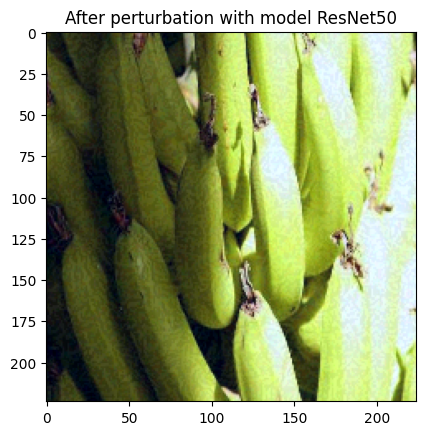

1/2: 0M5JU924BDT7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Classified as toaster with 0.9999326467514038% confidence.


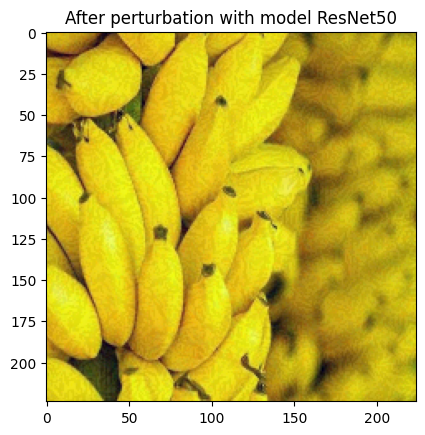

In [ ]:
full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/targeted2"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sub_images = image_files[:2]

model_name = "MobileNetV2"
model = {model_name: all_models[model_name]}

eps = 0.03
label = tf.Variable(954)
target_label = tf.Variable(859)
iterations = 200

advs_targeted = generate_adversarial_images(sub_images, model, full_path, target_path, label, target_label, eps, iterations)

In [30]:
full_path = "./adversarial_images/custom/"
target_path = "./adversarial_images/targeted2"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sub_images = image_files[:1]

model_name = "MobileNetV2"
model = {model_name: all_models[model_name]}

# Get label
image_raw = tf.io.read_file(full_path + sub_images[0])
image = tf.image.decode_image(image_raw)
image_pr = preprocess(image, model[model_name][1])
preds = model[model_name][0](image_pr,training=False)
print(tf.keras.applications.mobilenet_v2.decode_predictions(preds)[0])


eps = 0.01
label = tf.Variable(903)
target_label = tf.Variable(859)
iterations = 300

advs_targeted = generate_adversarial_images(sub_images, model, full_path, target_path, label, target_label, eps, iterations)

[('n04584207', 'wig', np.float32(0.66335285)), ('n02883205', 'bow_tie', np.float32(0.027764332)), ('n02791270', 'barbershop', np.float32(0.016251395)), ('n02992529', 'cellular_telephone', np.float32(0.013843027)), ('n04599235', 'wool', np.float32(0.012175696))]
0/1: ml.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Classified as toaster with 1.0% confidence.


## Untargeted attacks

In [9]:
def create_adversarial_pattern(input_image, input_label, loss_object, model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [10]:
def deprocess_resnet(image):
    if len(image.shape) == 4:
        image = image[0]
    
    image = image[..., ::-1]  # BGR → RGB
    image = image + [103.939, 116.779, 123.68]  # Unsubtract means
    image = tf.clip_by_value(image, 0.0, 255.0)
    return image / 255.0  # normalize for display


def generate_untargeted_adversarial_images_multiple_models(images, source_folder, target_folder, label, eps, models):

    i, mx = 0, len(images)
    label = tf.one_hot(label, 1000)
    label = tf.reshape(label, (1, 1000))
    adversarial_tensors = []

    for img_name in images:
        # print(f"{i + 1}/{mx}: {img_name}")

        # image_path = tf.keras.utils.get_file(img_name, 'file://' + source_folder + img_name)
        image_raw = tf.io.read_file(source_folder + img_name)
        image = tf.image.decode_image(image_raw)
        for j, m in enumerate(models.keys()):
            model = models[m][0]
            preprocessor = models[m][1]
            
            if m == "InceptionV3":
                image_pr = preprocess(image, preprocessor, (299, 299))
            elif m == "MobileNetV3" or m == "MobileNetV3Small":
                image_pr = preprocess(image, lambda x: x)
            else:
                image_pr = preprocess(image, preprocessor)

            # plt.imshow(image_pr[0])
            # plt.title("After preprocessing")
            # plt.show()

            loss_object = tf.keras.losses.CategoricalCrossentropy()
            pertubation = create_adversarial_pattern(image_pr, label, loss_object, model)
            # plt.imshow(pertubation[0] * 0.5 + 0.5)
            # plt.title(f"Perturbation with {m}")
            # plt.show()

            if m == "VGG16" or m == "ResNet50":
                adv = image_pr + 100 * eps * pertubation
                adv = tf.clip_by_value(adv, -128, 128)
                final = (deprocess_resnet(adv) - 0.5) * 2

                # tensor_range(depr)
                # plt.imshow(depr)
                # plt.show()
            elif m == "MobileNetV2" or m == "MobileNetV3Small" or m == "InceptionV3":
                adv = image_pr + eps * pertubation
                final = tf.clip_by_value(adv, -1, 1)
            elif m == "MobileNetV3" or m == "MobileNetV3Small":
                adv = image_pr + 255 * eps * pertubation
                final = tf.clip_by_value(adv, 0, 255)

            # Convert from [-1, 1] to [0, 255]
            tensor = (final + 1.0) / 2.0
            tensor = tf.clip_by_value(tensor, 0.0, 1.0)
            tensor = tf.image.convert_image_dtype(tensor, dtype=tf.uint8)

            if len(tensor.shape) == 4:
                tensor = tensor[0]
            # plt.imshow(tensor)
            # plt.title(f"After perturbation with model {m}")
            # plt.show()

            image = tensor
        save_image(tensor, target_folder, img_name)
        adversarial_tensors.append(tensor)
        # _, cl, conf = get_imagenet_label(all_models["MobileNetV2"][0].predict(preprocess(tensor, all_models["MobileNetV2"][1])))
        # print(f"Classified as {cl} with {conf}% confidence.")

        i += 1
        
    return adversarial_tensors

In [588]:
full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/untargeted/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files

model_name = "ResNet50"
model = {model_name: all_models[model_name]}
eps = 0.01
label = tf.Variable(954)


advs = generate_untargeted_adversarial_images_multiple_models(sub_images, full_path, target_path, label, eps, model)
# tensor_range(advs[0])
# advs[0]

1/100: BXGWH5LDSBVH.jpg
Image saved to: ./adversarial_images/untargeted/BXGWH5LDSBVH.jpg
2/100: 0M5JU924BDT7.jpg
Image saved to: ./adversarial_images/untargeted/0M5JU924BDT7.jpg
3/100: 67IKPXNTBPW4.jpg
Image saved to: ./adversarial_images/untargeted/67IKPXNTBPW4.jpg
4/100: ZP0SPW9WVAXD.jpg
Image saved to: ./adversarial_images/untargeted/ZP0SPW9WVAXD.jpg
5/100: MRBF5A4A1CJA.jpg
Image saved to: ./adversarial_images/untargeted/MRBF5A4A1CJA.jpg
6/100: P7UIOT2KVDET.jpg
Image saved to: ./adversarial_images/untargeted/P7UIOT2KVDET.jpg
7/100: NWQ45BLV4HUP.jpg
Image saved to: ./adversarial_images/untargeted/NWQ45BLV4HUP.jpg
8/100: 9G3QHFUWLQ22.jpg
Image saved to: ./adversarial_images/untargeted/9G3QHFUWLQ22.jpg
9/100: 74EEYDBZQQSJ.jpg
Image saved to: ./adversarial_images/untargeted/74EEYDBZQQSJ.jpg
10/100: WVGPEY52XK9O.jpg
Image saved to: ./adversarial_images/untargeted/WVGPEY52XK9O.jpg
11/100: O2TH8EXK41KR.jpg
Image saved to: ./adversarial_images/untargeted/O2TH8EXK41KR.jpg
12/100: ID4B9VD0XBK

In [517]:
full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/untargeted2/"
image_files = [f for f in os.listdir(full_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:100]

sub_images = image_files

# model_name = "MobileNetV2"
# model = {model_name: all_models[model_name]}
eps = 0.005
label = tf.Variable(954)

advs = generate_untargeted_adversarial_images_multiple_models(sub_images, full_path, target_path, label, eps, all_models)

1/100: BXGWH5LDSBVH.jpg
Image saved to: ./adversarial_images/untargeted2/BXGWH5LDSBVH.jpg
2/100: 0M5JU924BDT7.jpg
Image saved to: ./adversarial_images/untargeted2/0M5JU924BDT7.jpg
3/100: 67IKPXNTBPW4.jpg
Image saved to: ./adversarial_images/untargeted2/67IKPXNTBPW4.jpg
4/100: ZP0SPW9WVAXD.jpg
Image saved to: ./adversarial_images/untargeted2/ZP0SPW9WVAXD.jpg
5/100: MRBF5A4A1CJA.jpg
Image saved to: ./adversarial_images/untargeted2/MRBF5A4A1CJA.jpg
6/100: P7UIOT2KVDET.jpg
Image saved to: ./adversarial_images/untargeted2/P7UIOT2KVDET.jpg
7/100: NWQ45BLV4HUP.jpg
Image saved to: ./adversarial_images/untargeted2/NWQ45BLV4HUP.jpg
8/100: 9G3QHFUWLQ22.jpg
Image saved to: ./adversarial_images/untargeted2/9G3QHFUWLQ22.jpg
9/100: 74EEYDBZQQSJ.jpg
Image saved to: ./adversarial_images/untargeted2/74EEYDBZQQSJ.jpg
10/100: WVGPEY52XK9O.jpg
Image saved to: ./adversarial_images/untargeted2/WVGPEY52XK9O.jpg
11/100: O2TH8EXK41KR.jpg
Image saved to: ./adversarial_images/untargeted2/O2TH8EXK41KR.jpg
12/100: 